In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import STL
import pymc as pm
import seaborn as sns
from icecream import ic

### Data analysis

In [2]:
mmm_data = pd.read_csv("MMM_test_data.csv")

In [3]:
mmm_data['start_of_week'] = pd.to_datetime(mmm_data['start_of_week'], format="%d-%m-%y")

In [4]:
mmm_data.set_index('start_of_week', inplace=True)

In [5]:
mmm_data.head(10)

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
start_of_week,,,,,,,,
2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
2020-09-06,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48
2020-10-04,195581.04,3655.19,525.06,18024.45,9739.47,20804.05,25445.63,30394.41
2020-10-11,146951.61,6459.43,640.94,24012.09,7048.24,33009.65,33692.83,37544.71
2020-10-18,163640.65,2367.28,121.88,13718.53,3602.20,27609.98,14352.62,33966.36
2020-10-25,193045.15,1445.99,91.70,12026.26,3886.93,16244.03,8110.34,24494.61


In [6]:
mmm_data.tail(10)

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
start_of_week,,,,,,,,
2022-06-19,109330.80,0.0,663.62,18260.69,6871.29,3406.82,0.0,37994.99
2022-06-26,96935.55,0.0,724.87,19853.38,6826.65,3629.09,0.0,32639.33
2022-07-03,99827.27,0.0,213.28,30537.66,6738.55,3347.91,0.0,28663.43
2022-07-10,72222.52,0.0,322.67,17198.03,5737.36,3244.37,0.0,30159.33
2022-07-17,73682.25,0.0,295.03,18450.17,4830.59,3158.67,0.0,25295.06
2022-07-24,72021.50,0.0,1118.78,22305.10,4566.01,2987.70,0.0,19916.88
2022-07-31,90786.21,0.0,122.16,15812.65,4795.51,3293.40,0.0,22687.98
2022-08-07,105929.40,0.0,754.09,12166.85,4961.12,4057.03,0.0,30142.64
2022-08-14,90506.31,0.0,1043.22,10856.58,4431.13,3086.81,0.0,28622.78


In [7]:
mmm_data.describe().applymap(lambda x: f"{x:0.2f}")

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
count,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00
mean,136490.19,1245.60,343.64,19507.18,6915.14,8575.61,5063.70,27701.37
std,50810.25,1388.38,332.99,8714.76,3123.17,6956.79,6689.47,12176.29
min,63207.09,0.00,4.37,5938.13,3602.20,747.46,0.00,9391.21
25%,101675.68,334.27,120.47,13879.00,5113.94,2902.03,0.00,19797.71
50%,128790.46,856.87,202.02,17929.45,6194.40,6879.27,2423.10,24248.64
75%,157707.28,1658.03,553.08,22252.26,7470.56,14367.58,8701.96,33852.65
max,418186.38,8513.83,1605.85,49689.38,22629.69,33009.65,33692.83,77488.42


In [8]:
correlation_matrix = mmm_data.corr()
correlation_matrix

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
revenue,1.000000,0.323828,0.080848,0.381686,0.255698,0.421304,0.522644,0.249895
spend_channel_1,0.323828,1.000000,-0.107805,0.310750,0.306163,0.556469,0.514291,0.102148
spend_channel_2,0.080848,-0.107805,1.000000,0.276014,0.396803,-0.306958,-0.077497,0.588705
spend_channel_3,0.381686,0.310750,0.276014,1.000000,0.504139,0.037029,0.170534,0.496535
spend_channel_4,0.255698,0.306163,0.396803,0.504139,1.000000,-0.182030,0.013237,0.559980
spend_channel_5,0.421304,0.556469,-0.306958,0.037029,-0.182030,1.000000,0.650802,-0.274113
spend_channel_6,0.522644,0.514291,-0.077497,0.170534,0.013237,0.650802,1.000000,0.024605
spend_channel_7,0.249895,0.102148,0.588705,0.496535,0.559980,-0.274113,0.024605,1.000000


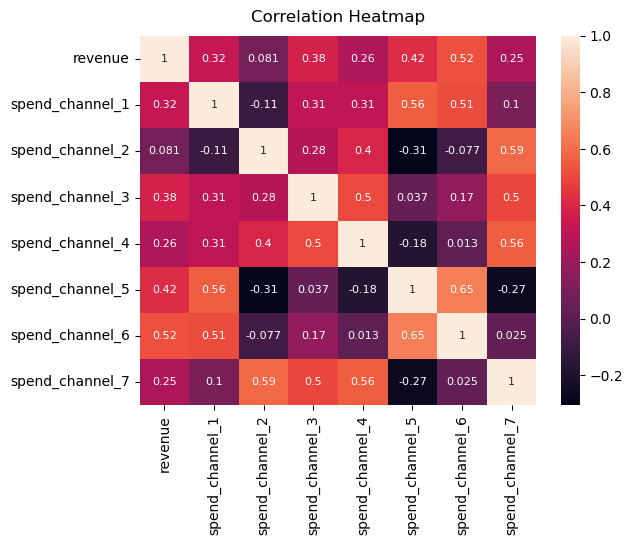

In [9]:
heatmap = sns.heatmap(mmm_data.corr(), annot=True, annot_kws={'size':8})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=10);


In [10]:
fig_channels = go.Figure()

for i in range(1, 8):
    fig_channels.add_trace(
        go.Scatter(x=mmm_data.index, y=mmm_data[f"spend_channel_{i}"],
        name=f"spend_channel_{i}"))
fig_channels.update_layout(
    title="Spend per channel over time",
    title_x=0.5)
fig_channels.show()

In [11]:
fig_revenue = go.Figure(data=go.Scatter(x=mmm_data.index, y=mmm_data['revenue'], name="revenue"))
fig_revenue.update_layout(
    title="Revenue over time",
    title_x=0.5)
fig_revenue.show()

In [12]:
result=STL(mmm_data['revenue'], seasonal=53).fit()

In [13]:
def plot_ts_decomposition(stl_result, data_frame, feature_name):
    
    fig =  make_subplots(rows=4, cols=1, subplot_titles=('Original timeseries', 'Seasonal effect',  'Trend effect', 'Residual effect'))

    fig.add_trace(
        go.Scatter(x=data_frame.index, y=data_frame[feature_name]),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=stl_result.seasonal.index, y=stl_result.seasonal.values),
        row=2, col=1
    )

    fig.add_trace(
        go.Scatter(x=stl_result.trend.index, y=stl_result.trend.values),
        row=3, col=1
    )

    fig.add_trace(
        go.Scatter(x=stl_result.resid.index, y=stl_result.resid.values),
        row=4, col=1
    )

    fig.update_layout(
        title_text=f"Decomposition of {feature_name} feature", 
        title_x=0.5,
        showlegend=False)

    return fig

In [14]:
decomposition = plot_ts_decomposition(result, mmm_data, "revenue")
decomposition.show()

## Adding trend and seasonality to the data and plotting timeseries decomposition for spend_channels

In [15]:

for i in range(1, 8):
    stl_result=STL(mmm_data[f"spend_channel_{i}"], seasonal=53).fit()
    mmm_data[f"spend_channel_{i}_seasonal"] = stl_result.seasonal.values
    mmm_data[f"spend_channel_{i}_trend"] = stl_result.trend.values
    decomposition_fig = plot_ts_decomposition(stl_result, mmm_data, f"spend_channel_{i}")
    decomposition_fig.show()

In [16]:
mmm_data = mmm_data.sort_index(axis=1)
mmm_data.head()

,revenue,spend_channel_1,spend_channel_1_seasonal,spend_channel_1_trend,spend_channel_2,spend_channel_2_seasonal,spend_channel_2_trend,spend_channel_3,spend_channel_3_seasonal,spend_channel_3_trend,...,spend_channel_4_trend,spend_channel_5,spend_channel_5_seasonal,spend_channel_5_trend,spend_channel_6,spend_channel_6_seasonal,spend_channel_6_trend,spend_channel_7,spend_channel_7_seasonal,spend_channel_7_trend
start_of_week,,,,,,,,,,,,,,,,,,,,,
2020-08-30,157906.75,2625.48,224.010399,2401.469601,262.71,323.394889,-60.684889,12954.12,-5102.507574,18056.627574,...,5266.163835,12955.29,-6240.182788,19195.472788,12659.12,1526.053291,11133.066709,19379.79,5500.986050,13878.803950
2020-09-06,186425.68,2634.01,253.304009,2380.705991,108.66,162.731864,-54.071864,8760.28,-9339.465499,18099.745499,...,5307.443857,12747.70,-6234.262866,18981.962866,12338.18,1342.353373,10995.826627,22473.45,8337.055011,14136.394989
2020-09-13,161607.39,2087.08,-272.862382,2359.942382,110.32,157.778839,-47.458839,7155.42,-10987.443425,18142.863425,...,5348.723879,15015.41,-3753.042944,18768.452944,10811.15,-47.436546,10858.586546,22596.05,8202.063972,14393.986028
2020-09-20,180089.13,1690.70,-648.478772,2339.178772,52.79,93.635814,-40.845814,15185.22,-3000.761350,18185.981350,...,5390.003902,15521.41,-3033.533021,18554.943021,12890.22,2168.873536,10721.346464,24728.73,10077.152933,14651.577067
2020-09-27,217793.98,1547.30,-771.115163,2318.415163,80.56,114.792788,-34.232788,18524.05,294.950725,18229.099275,...,5431.283924,15793.74,-2547.693099,18341.433099,12642.55,2058.443617,10584.106383,26515.48,11606.311893,14909.168107


### Modelling carryover effect

In [17]:
def geometric_decay(alpha, L):
    """Returns list of weights according to the geometric decay for calculating adstock carryover effect.

    :param alpha: retention rate of ad effect, 0 < alpha 1.
    :param L: length of the carryover effect.

    :return: list of weights
    """
    return [alpha**(l)for l in range(L)]

In [18]:
def delayed_adstock(alpha, L, theta):
    """Returns list of weights according to the delayed adstock for calculating adstock carryover effect.

    :param alpha: retention rate of ad effect, 0 < alpha 1.
    :param L: length of the carryover effect.
    :param theta: delay of the peak effect, 0 <= theta <= L-1

    :return: list of weights
    """
    return [alpha**((l-theta)**2)for l in range(L)]

In [19]:
def adstock_carryover(x, weights, L):
    """Returns adstock carryover effect.

    :param x: vector with media spend data, its length should be equal to L.
    :param wieghts: weight values from the decay function, its length should be equal to L.
    :param L: length of the carryover effect.

    :return: modified media spend data with carryover effect.
    """
    numerator = sum([weights[l] * x[-l] for l in range(L)])
    denominator = sum([weights[l] for l in range(L)])
    return numerator / denominator

### Decays visualizaitons

In [20]:
L = 5

alpha_list = [round(i*0.1+0.1, 1) for i in range(L)]
theta_list = [i for i in range(L)]


fig_decays = go.Figure()

fig_decays.add_trace(
    go.Scatter(x=np.arange(0, L+1, 0.05), y=[0.3**(l)for l in np.arange(0, L+1, 0.05)],
    name=f"geometric decay", mode='lines'))

fig_decays.add_trace(
    go.Scatter(x=np.arange(0, L+1, 0.05), y=[0.3**((l-3)**2)for l in np.arange(0, L+1, 0.05)],
    name=f"adstock decay", mode='lines'))

fig_decays.update_layout(
    title="Visualization of geometric and adstock decays",
    title_x=0.5)
fig_decays.show()

In [21]:
parameters_fig = go.Figure()

for i in alpha_list:
    parameters_fig.add_trace(
        go.Scatter(x=list(range(L)), y=geometric_decay(alpha=i, L=L),
        name=f"alpha={i}", mode='lines'))

parameters_fig.update_layout(
    title="Visualization of different alpha parameter for geometric decay",
    title_x=0.5)
parameters_fig.show()

In [22]:
parameters_fig = go.Figure()

for i in theta_list:
    parameters_fig.add_trace(
        go.Scatter(x=list(range(L+3)), y=delayed_adstock(alpha=0.3, theta=i, L=L+3),
        name=f"theta={i}", mode='lines'))

parameters_fig.update_layout(
    title="Visualization of different theta parameter for geometric decay",
    title_x=0.5)
parameters_fig.show()

### Applying Carryover Effect

In [23]:
def transform_data(data, alpha, L, theta=None, decay_type="delayed_adstock"):
    """Transforms entire media spend series using adstock function.
    :param data: vector with media spend data.
    :param alpha: retention rate of ad effect, 0 < alpha 1.
    :param L: length of the carryover effect.
    :param theta: delay of the peak effect, 0 <= theta <= L-1
    :param decay_type: type of the function used to calculate weights.

    :return: transformed media spend vector.
    """
    
    results = []

    if decay_type=="delayed_adstock":
        weights = delayed_adstock(alpha, L, theta)
    elif decay_type=="geometric_decay":
        weights = geometric_decay(alpha, L)
    
    for t, val in enumerate(data, 1):
        current_window = data[max(t-L, 0):t] # max function is used to handle beginning of the sequence when t<L
        transformed_data = adstock_carryover(x=current_window, weights=weights, L=len(current_window))
        results.append(transformed_data)
    
    return results
    

In [24]:
spend_channel_1 = mmm_data['spend_channel_1'].values
spend_channel_1_adstock = transform_data(spend_channel_1, alpha=0.3, L=12, theta=4, decay_type="delayed_adstock")
spend_channel_1_geo = transform_data(spend_channel_1, alpha=0.3, L=12, decay_type="geometric_decay")

adstock_carryover_fig = go.Figure()


adstock_carryover_fig.add_trace(
    go.Scatter(x=np.arange(len(spend_channel_1)), y=spend_channel_1,
    name=f"Original data", mode='lines'))

adstock_carryover_fig.add_trace(
    go.Scatter(x=np.arange(len(spend_channel_1_geo)), y=spend_channel_1_geo,
    name=f"Geometric delay", mode='lines'))

adstock_carryover_fig.add_trace(
    go.Scatter(x=np.arange(len(spend_channel_1_adstock)), y=spend_channel_1_adstock,
    name=f"Delayed adstock", mode='lines'))

adstock_carryover_fig.update_layout(
    title="Visualization of different carryover effects",
    title_x=0.5)
adstock_carryover_fig.show()

In [ ]:
spend_columns = [f"spend_channel_{i}" for i in range(1, 8)]
seasonal_columns = [f"spend_channel_{i}_seasonal" for i in range(1, 8)]
trend_columns = [f"spend_channel_{i}_trend" for i in range(1, 8)]

# Set up model context
with pm.Model() as mixed_media_model:
    # Define priors
    alpha = pm.Beta("alpha", alpha=3, beta=3)
    theta = pm.Uniform("theta", 0, 12)
    beta = pm.HalfNormal("beta", shape=(7,))
    
    gamma_season = pm.Normal("gamma_season", 0, 1, shape=(7,))
    gamma_trend = pm.Normal("gamma_trend", 0, 1, shape=(7,))
    error = pm.InverseGamma("error", 0.05, 0.0005)
    
    L = 13

    target = mmm_data['revenue'].values

    transformed_spend_data = np.array([transform_data(mmm_data[media_spend], alpha=alpha, L=L, theta=theta, decay_type="delayed_adstock")*beta_val for media_spend, beta_val in zip(spend_columns, beta)]).sum(axis=0)
    season_part_data = np.array([mmm_data[season_col].values*gamma_val for season_col, gamma_val in zip(seasonal_columns, gamma_season)]).sum(axis=0)
    trend_part_data = np.array([mmm_data[trend_col].values*gamma_val for trend_col, gamma_val in zip(trend_columns, gamma_trend)]).sum(axis=0)

    mu = transformed_spend_data + season_part_data + trend_part_data

    predictions = pm.Normal('predictions', mu=mu, sigma=error, observed=target)
    
    trace = pm.sample(n_chains=2, n_samples=1000, step=pm.NUTS(), progressbar=False)

    
